Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data ovarian
url = "https://raw.githubusercontent.com/jamessaldo/final-task/master/ovarian_61902.data"
data_ovarian = pd.read_csv(url, header=None)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada Data Ovarian Cancer:',data_ovarian.isnull().sum().sum())

Total Missing Value pada Data Ovarian Cancer: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data ovarian
data_new_ovarian = data_ovarian.drop([15154],axis=1)
scaler = MinMaxScaler()
data_new_ovarian = scaler.fit_transform(data_new_ovarian)
data_new_ovarian = DataFrame(data_new_ovarian)
data_new_ovarian['label'] = list(data_ovarian[15154])
dic = {'Normal':0,'Cancer':1}
data_new_ovarian.replace(dic,inplace=True)

# 2. Define Reusable Function

## Fitness Function

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
def fitness(dataset, orde):
  start = timeit.default_timer()
  X = pd.DataFrame(dataset.iloc[:, 0:len(dataset.columns)-1].values)
  Y = pd.DataFrame(dataset.iloc[:, len(dataset.columns)-1].values)

  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # # Melakukan proses klasifikasi LR
  X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)
  # Inisialisasi FLNN
  Model = Sequential()
  # Menambah input layer dan hidden layer pertama
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
  # Menambah hidden layer kedua
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu'))
  # Menambah output layer
  Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  # Menjalankan ANN
  Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
  # Fitting ANN ke training set
  history = Model.fit(X_train, y_train, batch_size = 35, epochs = 100, validation_split = 0.2, verbose=False)

  #Memprediksi hasil test set
  y_pred = Model(X_test)
  y_pred =(y_pred >= 0.5)

  F1 = f1_score(y_test, y_pred, average='macro')

  print("F1 Score : ", F1)

  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return F1

## FLNN Classifier

In [6]:
def FLNN_Classifier(dataset, cancer_name, orde):
  start = timeit.default_timer()
  X = dataset.drop(['label'], axis=1)
  Y = dataset['label']
  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y.reset_index().label
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # Melakukan proses K-Fold
  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
  kf.get_n_splits(df_)

  # Melakukan proses klasifikasi FLNN
  Hasil_Akurasi = []
  Hasil_F1 = []
  for train_index, test_index in kf.split(X,Y):
    print("Train :" , train_index, "Test :", test_index)
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], label[train_index], label[test_index]
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
    # Menambah hidden layer kedua
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu'))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 35, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    hasil = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')
    #F1 = f1_score(y_test, y_pred, average)

    print("Akurasi : ", hasil)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))
    Hasil_Akurasi.append(hasil)
    Hasil_F1.append(F1)

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

  Akurasi = np.array(Hasil_Akurasi)
  F1_Score = np.array(Hasil_F1)
  avg_akurasi = Akurasi.mean()
  avg_F1 = F1_Score.mean()

  print("avg accuraccy "+cancer_name+" = ",avg_akurasi)
  print("avg F1_Score "+cancer_name+" = ",avg_F1)

  print("max accuraccy "+cancer_name+" = ",Akurasi.max())
  print("max F1_Score "+cancer_name+" = ",F1_Score.max())

  print("min accuraccy "+cancer_name+" = ",Akurasi.min())
  print("min F1_Score "+cancer_name+" = ",F1_Score.min())
  
  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return avg_akurasi, avg_F1

## Genetic Algorithm

In [7]:
# define parameters
mutationRate = 0.1
crossoverRate = 0.8
populationSize = 10
maxGen = 5

def GenerateGene(lengthOfGen):
  genes = [] # menyimpan index feature
  for j in range(lengthOfGen):
    genes.append(random.randint(0,1))
  return genes

def GeneratePopulation(lengthOfGen):
  population = []
  for i in range(populationSize):
    individu = GenerateGene(lengthOfGen)
    population.append(individu)
  return population

def CrossOver(parent_1, parent_2, rate, lengthOfGen): #Random Point Method
  new_pop = [] 
  for i in range((populationSize - 2) // 2):
    if random.random() < rate:
      CP = random.randint(0,lengthOfGen) #CrossPoint
      child = parent_1[0:CP] + parent_2[CP:len(parent_2)]
      new_pop.append(child)
      child = parent_2[0:CP] + parent_1[CP:len(parent_1)]
      new_pop.append(child)
    else:
      new_pop.append(parent_1)
      new_pop.append(parent_2)
  return new_pop

def Mutation(mutant, rate, lengthOfGen):
  for i in range(len(mutant)):
    # memutasi tiap gen yang memiliki kemungkinan < rate(0.1)
    for j in range(lengthOfGen):
      if random.random() <= rate:
        mutant[i][j] = 1 - mutant[i][j]
  return mutant

def ZeroGene(indv): #pengecekan apakah gen isinya kosong atau tidak
  total = 0
  for i in range(len(indv)):
    if indv[i] == 0:
      total += 1
  if len(indv) == total:
    return True
  else:
    return False

def Classification(indv, dataset, orde): #using Entropy as fitness
  datasetGA = pd.DataFrame()
  idxDatasetGA = 0
  for i in range(len(dataset.columns)-1):
    if indv[i] == 1:
      datasetGA[idxDatasetGA] = dataset[i]
      idxDatasetGA += 1
  datasetGA['label'] = dataset['label']
  Acc_score, F1_score = FLNN_Classifier(datasetGA, "Ovarian Cancer", orde)
  totalFeatures = idxDatasetGA+1
  return Acc_score, F1_score, totalFeatures

In [8]:
def GeneticAlgorithm(dataset,orde):
  start = timeit.default_timer()
  # Initial Population
  lengthOfGen = len(dataset.columns) - 1 # panjang gene = panjang fitur tanpa label

  # fintess evaluation
  bestF1 = 0
  bestAcc = 0
  bestNFeature = len(dataset.columns) - 1
  best_gene = []
  best_gene_2 = []
  population = GeneratePopulation(lengthOfGen) # Generate 1st Generation
  generation = 0 #max generation = 2**len(feature)

  while (generation < maxGen and (bestF1*100) < 99.5):
    print('Generation :',generation)
    fitness = pd.DataFrame()
    acc = []
    f1score = []
    # ent = []
    nFeature = []
    gene = []
    i = 0
    while (i < len(population)):
      if ZeroGene(population[i]) == False:
        print('gene :', population[i])
        accuracy, f1, totalFeatures = Classification(population[i], dataset, orde) # Count Fitness Value
        acc.append(accuracy)
        f1score.append(f1)
        nFeature.append(totalFeatures)
        gene.append(population[i])
      i += 1

    fitness['gene'] = gene
    fitness['feature'] = nFeature
    fitness['f1_score'] = f1score
    fitness['accuracy'] = acc

    fitness = fitness.sort_values(['f1_score'],ascending=False)
    
    last_bestF1 = bestF1
    last_bestAcc = bestAcc
    last_bestNFeature = bestNFeature
    last_best_gene = best_gene
    last_best_gene_2 = best_gene_2
    
    if last_bestF1 > fitness['f1_score'][fitness.index[0]]:
        bestF1 = last_bestF1
        bestAcc = last_bestAcc
        bestNFeature = last_bestNFeature
        # select parent
        best_gene = last_best_gene
        best_gene_2 = last_best_gene_2
    else:
        bestF1 = fitness['f1_score'][fitness.index[0]]
        bestAcc = fitness['accuracy'][fitness.index[0]]
        bestNFeature = fitness['feature'][fitness.index[0]]
        # select parent
        best_gene = fitness['gene'][fitness.index[0]].copy()
        best_gene_2 = fitness['gene'][fitness.index[1]].copy()

    #Crossover methods: Fixed Point, "Random Point", Alternate Point
    population = CrossOver(best_gene.copy(), best_gene_2.copy(), crossoverRate, lengthOfGen)

    # Mutation
    population = Mutation(population, mutationRate, lengthOfGen)

    # Masukkan best child tadi
    population.append(best_gene)
    population.append(best_gene_2)

    # Print Result
    print('===============================================================================================================================================================================================================')
    print('gen terbaik :', best_gene)
    print('F-1 Score terbaik :',bestF1,' || Akurasi terbaik :',bestAcc,' || jumlah fitur :',bestNFeature)
    print()

    # New Generation
    generation += 1
  listDrop = []
  for i in range(len(dataset.columns)-1):
    if best_gene[i] == 0:
      listDrop.append(dataset.columns[i])
  dataset_GA = dataset.drop(listDrop, axis = 1)
  stop = timeit.default_timer()
  print('Running Time: ', stop - start)
  return dataset_GA

# 3. Feature Selection with IG

## Ovarian

In [9]:
data_X = data_new_ovarian.drop(['label'],axis=1)
data_Y = data_new_ovarian['label']

X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.3, random_state=0)

sel_k_best = SelectKBest(mutual_info_classif, k=100)
sel_k_best.fit(data_X, data_Y)
data_X_new = sel_k_best.transform(data_X)

Ovarian_IG = pd.DataFrame(data_X_new)
Ovarian_IG['label'] = data_Y
useddata_ovarian = Ovarian_IG
print(useddata_ovarian.shape)
Ovarian_IG

(253, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.587691,0.518703,0.443787,0.580562,0.547371,0.528057,0.518906,0.494357,0.459559,0.444553,...,0.463763,0.450323,0.436837,0.423317,0.410290,0.397089,0.383253,0.405091,0.489925,0
1,0.203077,0.201995,0.159764,0.438963,0.412020,0.393901,0.351084,0.287801,0.235242,0.315143,...,0.414624,0.394852,0.380587,0.368825,0.359251,0.350508,0.344647,0.370498,0.403389,0
2,0.729230,0.760598,0.816568,0.925450,0.840814,0.732053,0.734485,0.750176,0.754143,0.786007,...,0.417813,0.405921,0.394501,0.385070,0.376203,0.364779,0.352929,0.372560,0.463820,0
3,0.495385,0.536160,0.618343,0.751834,0.694304,0.589654,0.538837,0.538375,0.532208,0.574547,...,0.761199,0.739266,0.717486,0.691793,0.662878,0.625934,0.572537,0.562206,0.611943,0
4,0.572307,0.553616,0.757397,0.785391,0.664077,0.559566,0.541541,0.569469,0.586319,0.673358,...,0.315772,0.305440,0.297445,0.291321,0.284793,0.276187,0.262607,0.266072,0.331163,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.384614,0.341646,0.434911,0.666935,0.530739,0.438363,0.457935,0.484851,0.506887,0.578640,...,0.566985,0.546548,0.528271,0.510913,0.494692,0.478701,0.455466,0.459088,0.487274,1
249,0.338460,0.274313,0.331361,0.589203,0.409054,0.301608,0.292861,0.314072,0.314105,0.461898,...,0.380840,0.368663,0.360299,0.355046,0.351128,0.346620,0.345355,0.364503,0.421004,1
250,0.338460,0.236908,0.360947,0.649017,0.504573,0.369336,0.352392,0.364739,0.365628,0.502826,...,0.297263,0.288228,0.282664,0.279517,0.276060,0.271038,0.265430,0.275394,0.328593,1
251,0.218461,0.206983,0.295858,0.473459,0.357393,0.246914,0.219111,0.230251,0.235449,0.307737,...,0.816336,0.780360,0.742990,0.709750,0.674583,0.645164,0.602724,0.581482,0.616833,1


# 4. Classification

## Ovarian + IG

Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 119 120 121 122 123 124 125 126 127 129 132 134
 135 138 139 140 142 143 144 146 147 148 149 150 151 152 153 154 155 156
 157 158 160 161 162 164 165 166 167 168 169 170 171 172 173 174 175 178
 179 180 182 183 185 186 187 188 190 191 193 194 196 197 198 199 200 201
 202 203 204 205 206 207 208 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 230 231 232 235 236 237 238 239 240 242 243
 245 246 247 252] Test : [  2  12  15  22  27  34  35  43  46  52  60  65  70  79  80  83  85  89
  90 102 104 116 118 128 130 131 133 136 137 141 145 159 163 176 177 181
 184 189 192 195 2

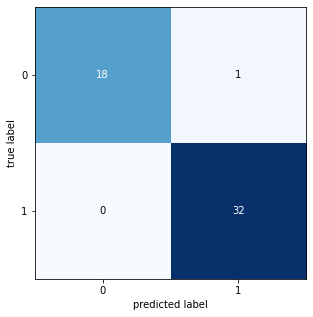

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

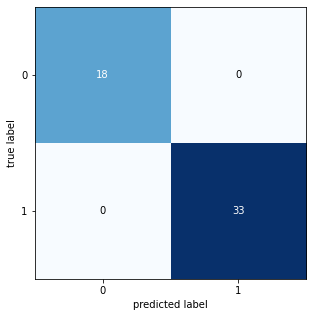

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

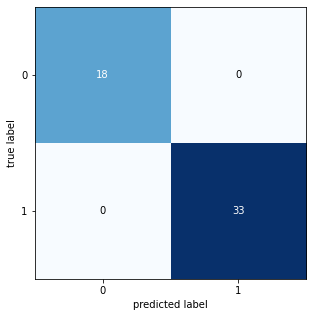

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

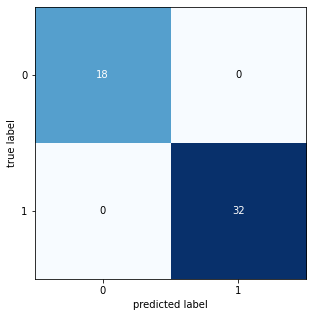

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

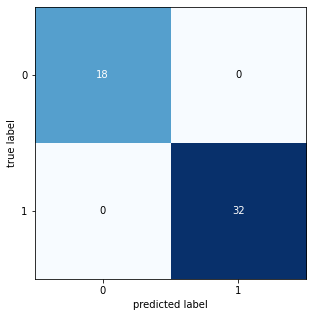

avg accuraccy Ovarian cancer =  0.996078431372549
avg F1_Score Ovarian cancer =  0.9957588357588356
max accuraccy Ovarian cancer =  1.0
max F1_Score Ovarian cancer =  1.0
min accuraccy Ovarian cancer =  0.9803921568627451
min F1_Score Ovarian cancer =  0.9787941787941788
Running Time:  36.986811078000756


(0.996078431372549, 0.9957588357588356)

In [10]:
FLNN_Classifier(Ovarian_IG,"Ovarian cancer",2)

Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 119 120 121 122 123 124 125 126 127 129 132 134
 135 138 139 140 142 143 144 146 147 148 149 150 151 152 153 154 155 156
 157 158 160 161 162 164 165 166 167 168 169 170 171 172 173 174 175 178
 179 180 182 183 185 186 187 188 190 191 193 194 196 197 198 199 200 201
 202 203 204 205 206 207 208 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 230 231 232 235 236 237 238 239 240 242 243
 245 246 247 252] Test : [  2  12  15  22  27  34  35  43  46  52  60  65  70  79  80  83  85  89
  90 102 104 116 118 128 130 131 133 136 137 141 145 159 163 176 177 181
 184 189 192 195 2

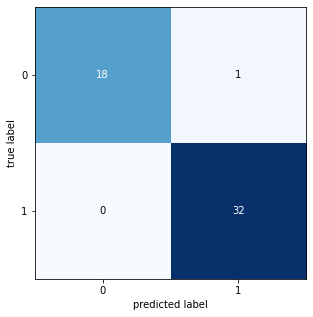

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

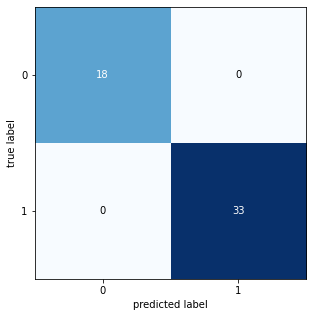

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

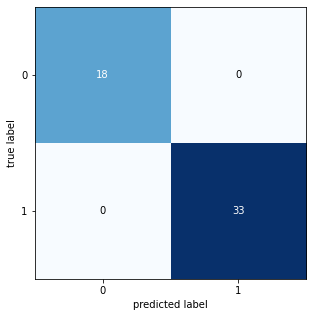

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

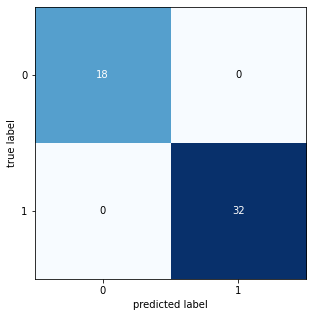

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

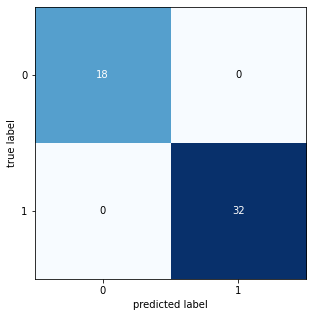

avg accuraccy Ovarian cancer =  0.996078431372549
avg F1_Score Ovarian cancer =  0.9957588357588356
max accuraccy Ovarian cancer =  1.0
max F1_Score Ovarian cancer =  1.0
min accuraccy Ovarian cancer =  0.9803921568627451
min F1_Score Ovarian cancer =  0.9787941787941788
Running Time:  38.34229525700357


(0.996078431372549, 0.9957588357588356)

In [11]:
FLNN_Classifier(Ovarian_IG,"Ovarian cancer",3)

Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 119 120 121 122 123 124 125 126 127 129 132 134
 135 138 139 140 142 143 144 146 147 148 149 150 151 152 153 154 155 156
 157 158 160 161 162 164 165 166 167 168 169 170 171 172 173 174 175 178
 179 180 182 183 185 186 187 188 190 191 193 194 196 197 198 199 200 201
 202 203 204 205 206 207 208 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 230 231 232 235 236 237 238 239 240 242 243
 245 246 247 252] Test : [  2  12  15  22  27  34  35  43  46  52  60  65  70  79  80  83  85  89
  90 102 104 116 118 128 130 131 133 136 137 141 145 159 163 176 177 181
 184 189 192 195 2

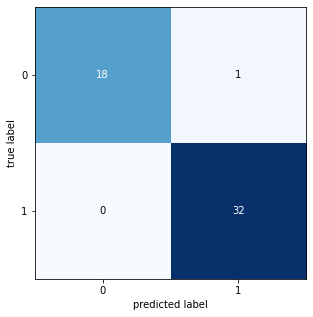

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

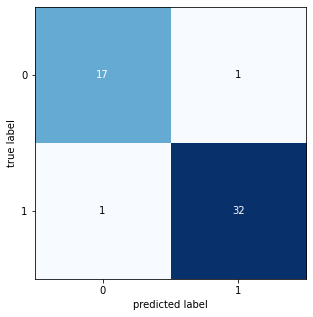

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

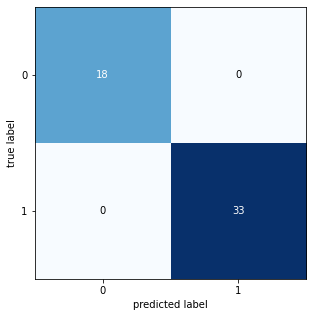

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

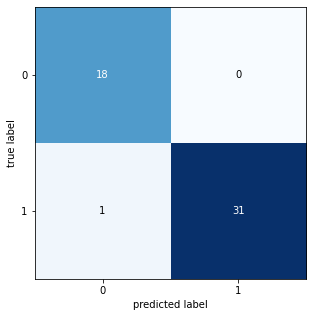

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

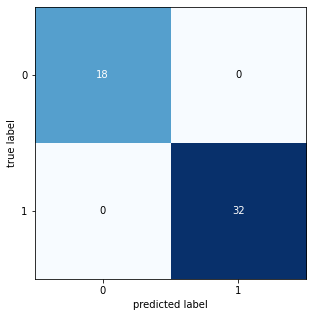

avg accuraccy Ovarian cancer =  0.9842352941176472
avg F1_Score Ovarian cancer =  0.9828829728829728
max accuraccy Ovarian cancer =  1.0
max F1_Score Ovarian cancer =  1.0
min accuraccy Ovarian cancer =  0.9607843137254902
min F1_Score Ovarian cancer =  0.9570707070707071
Running Time:  40.14314486299554


(0.9842352941176472, 0.9828829728829728)

In [12]:
FLNN_Classifier(Ovarian_IG,"Ovarian cancer",4)

## Ovarian + IG + GA

Generation : 0
gene : [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 119 120 121 122 123 124 125 126 127 129 132 134
 135 138 139 140 142 143 144 146 147 148 149 150 151 152 153 154 155 156
 157 158 160 161 162 164 165 166 167 168 169 170 171 172 173 174 175 178
 179 180 182 183 185 186 187 188 190 191 193 194 196 197 198 199 200 201
 202 203 204

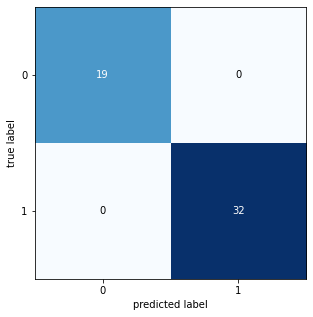

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

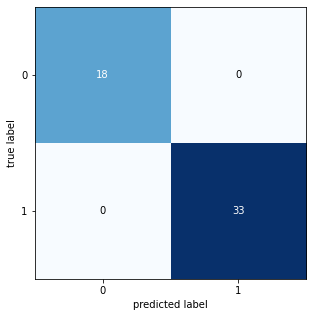

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

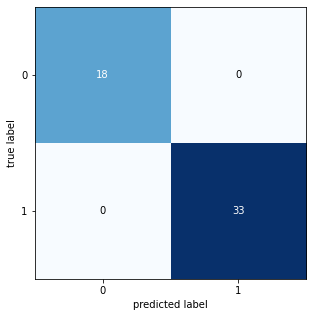

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

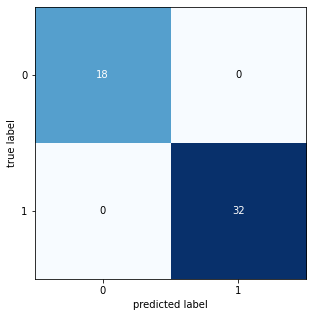

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

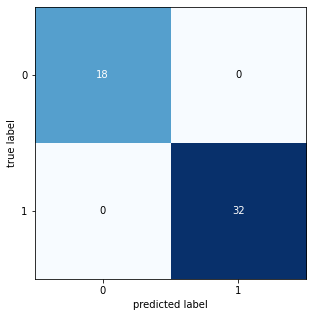

avg accuraccy Ovarian Cancer =  1.0
avg F1_Score Ovarian Cancer =  1.0
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  1.0
min F1_Score Ovarian Cancer =  1.0
Running Time:  48.09921138900245
gene : [1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 119 120 121 122 123 124 125 126 127 129 132 134


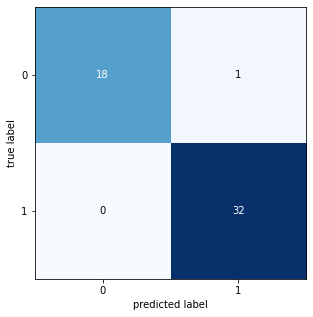

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

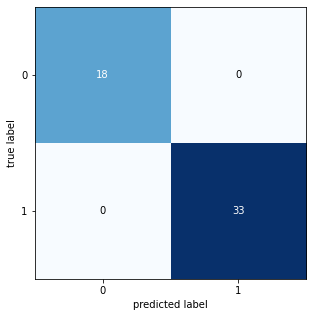

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

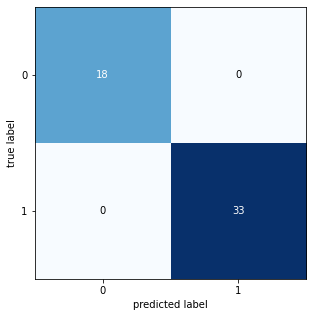

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

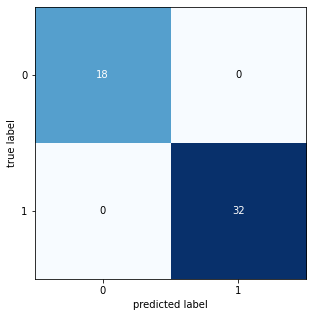

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

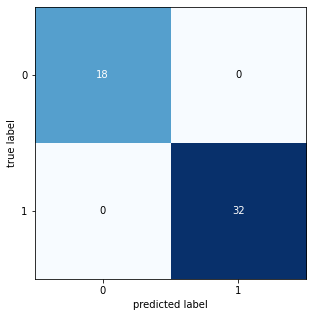

avg accuraccy Ovarian Cancer =  0.996078431372549
avg F1_Score Ovarian Cancer =  0.9957588357588356
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  45.81488364899997
gene : [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 1

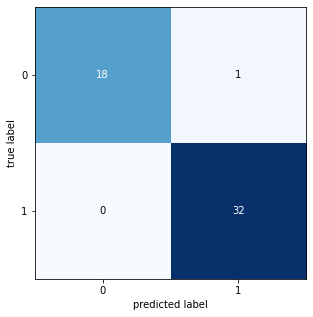

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

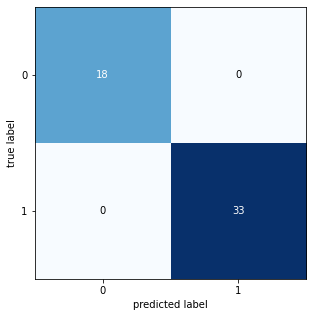

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

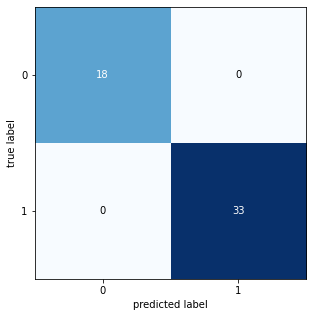

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

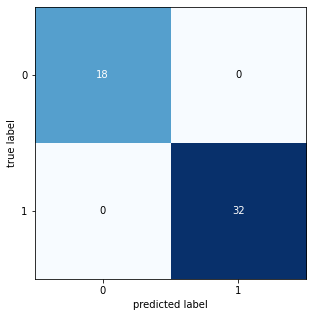

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

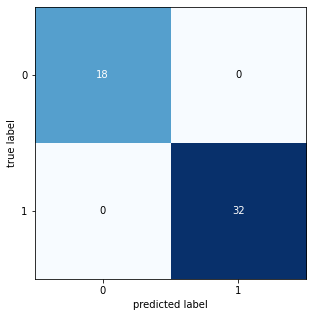

avg accuraccy Ovarian Cancer =  0.996078431372549
avg F1_Score Ovarian Cancer =  0.9957588357588356
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  47.19035050099774
gene : [1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 1

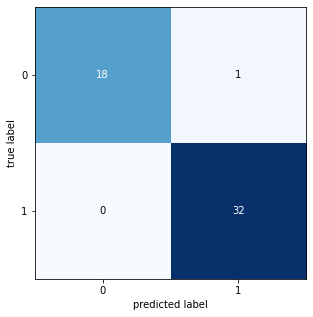

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

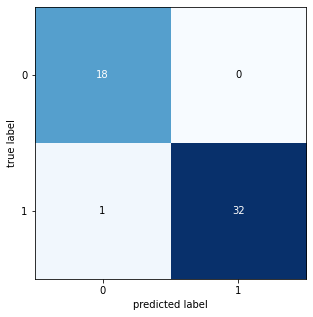

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

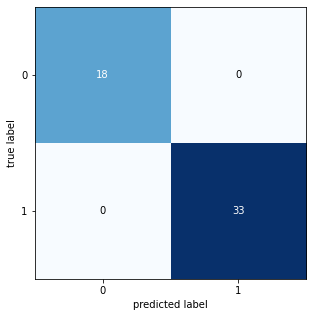

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

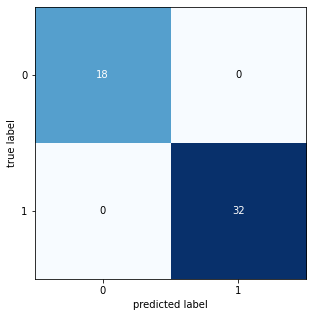

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

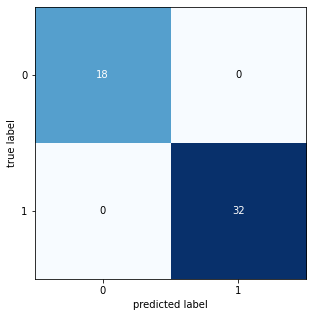

avg accuraccy Ovarian Cancer =  0.9921568627450981
avg F1_Score Ovarian Cancer =  0.9915176715176715
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  46.24674228799995
gene : [1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 

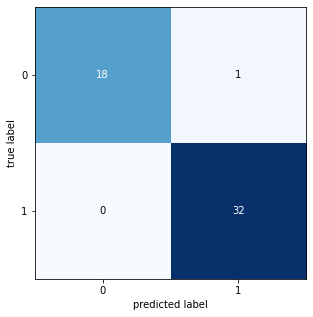

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

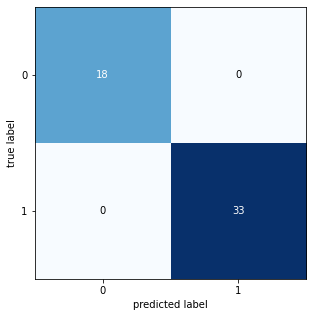

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

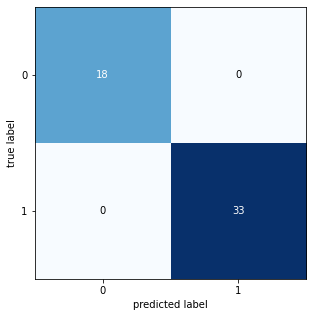

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

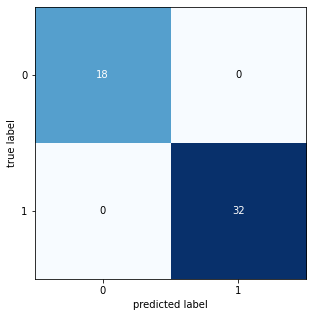

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

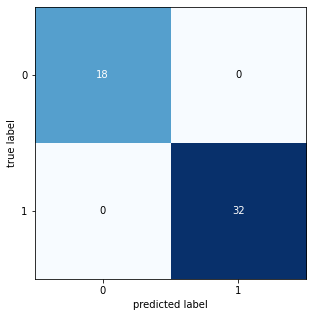

avg accuraccy Ovarian Cancer =  0.996078431372549
avg F1_Score Ovarian Cancer =  0.9957588357588356
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  46.17067118200066
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 1

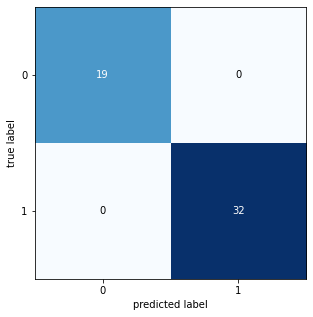

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

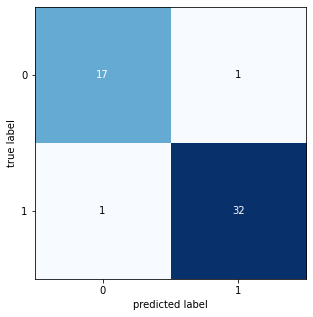

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

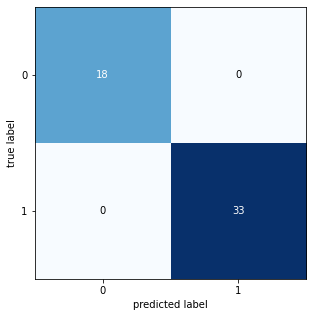

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

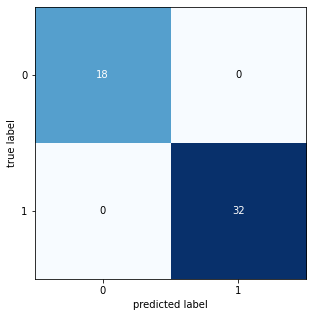

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

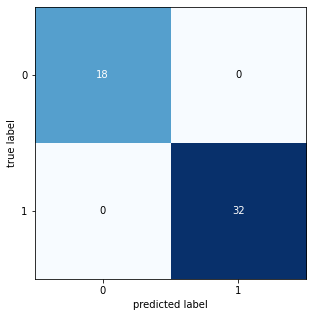

avg accuraccy Ovarian Cancer =  0.9921568627450981
avg F1_Score Ovarian Cancer =  0.9914141414141415
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9607843137254902
min F1_Score Ovarian Cancer =  0.9570707070707071
Running Time:  45.738483847999305
gene : [0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113

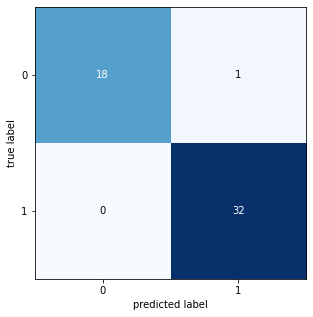

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

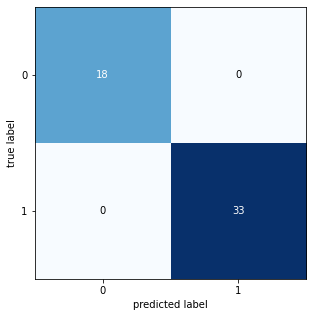

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

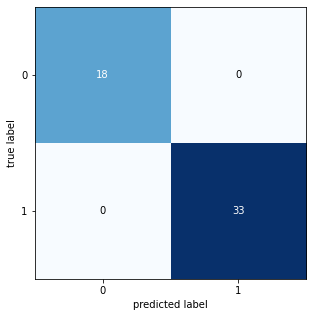

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

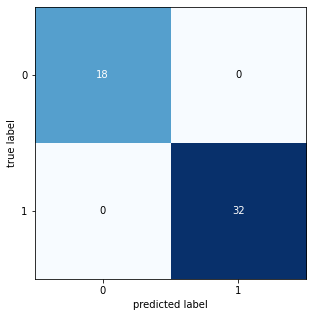

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

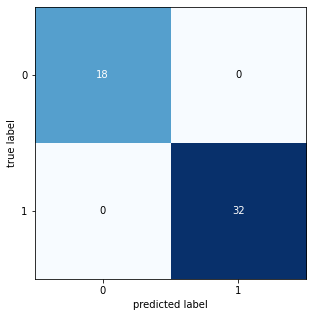

avg accuraccy Ovarian Cancer =  0.996078431372549
avg F1_Score Ovarian Cancer =  0.9957588357588356
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  47.03130087500176
gene : [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 1

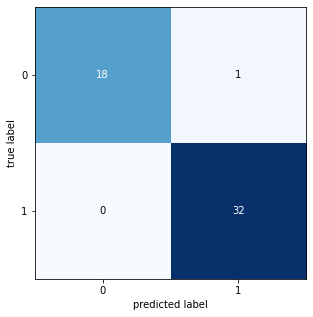

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

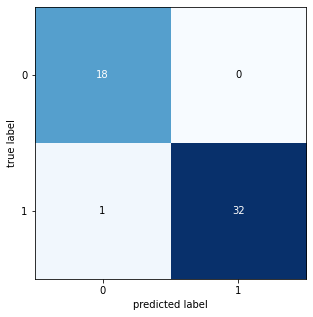

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

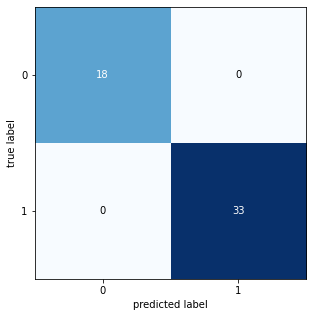

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

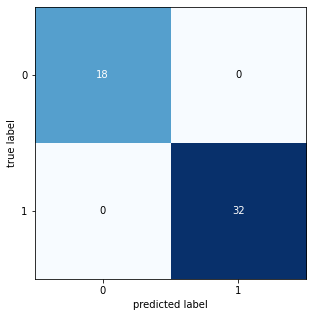

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

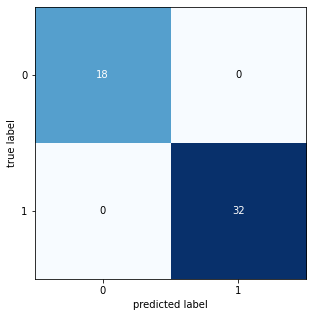

avg accuraccy Ovarian Cancer =  0.9921568627450981
avg F1_Score Ovarian Cancer =  0.9915176715176715
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  46.20998570899974
gene : [0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 

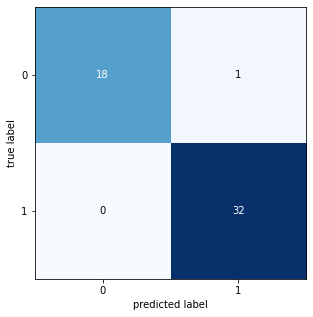

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

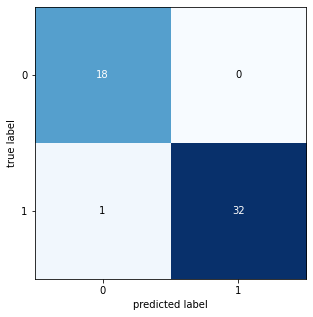

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

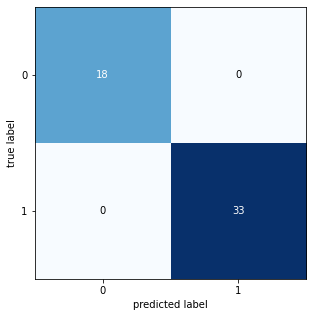

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

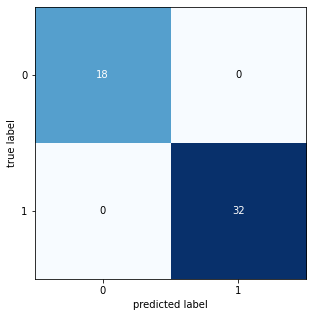

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

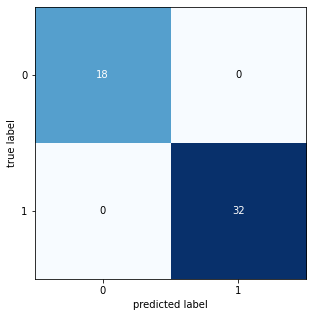

avg accuraccy Ovarian Cancer =  0.9921568627450981
avg F1_Score Ovarian Cancer =  0.9915176715176715
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  47.052998972998466
gene : [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113

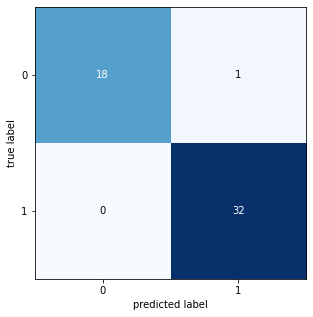

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

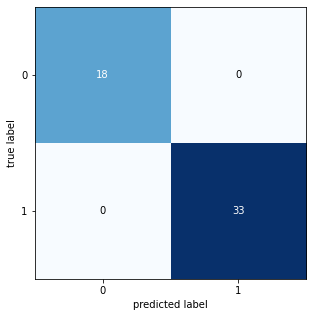

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

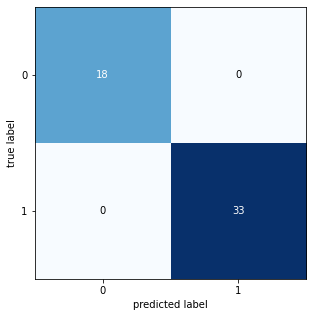

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

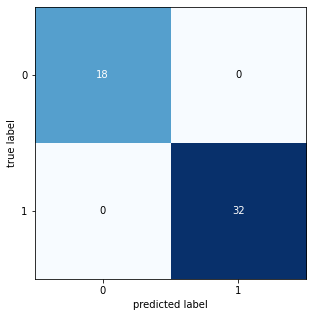

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

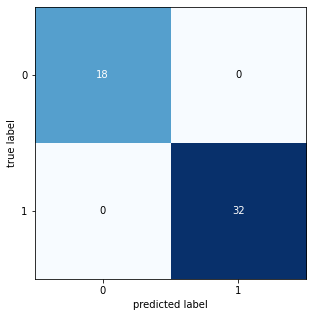

avg accuraccy Ovarian Cancer =  0.996078431372549
avg F1_Score Ovarian Cancer =  0.9957588357588356
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  46.40220024500013
gen terbaik : [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]
F-1 Score terbaik : 1.0  || Akurasi terbaik : 1.0  || jumlah fitur : 57

Running Time:  466.2321743640059


In [13]:
Ovarian_IG_GA = GeneticAlgorithm(Ovarian_IG, 2)

Generation : 0
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 119 120 121 122 123 124 125 126 127 129 132 134
 135 138 139 140 142 143 144 146 147 148 149 150 151 152 153 154 155 156
 157 158 160 161 162 164 165 166 167 168 169 170 171 172 173 174 175 178
 179 180 182 183 185 186 187 188 190 191 193 194 196 197 198 199 200 201
 202 203 204

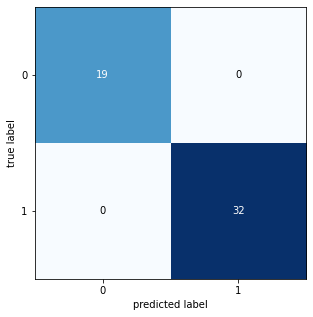

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

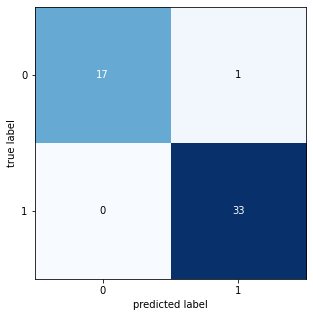

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

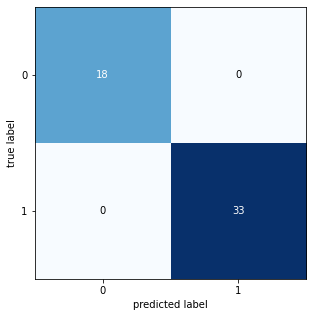

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

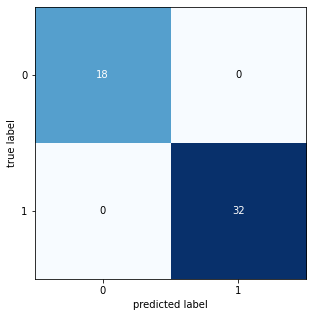

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

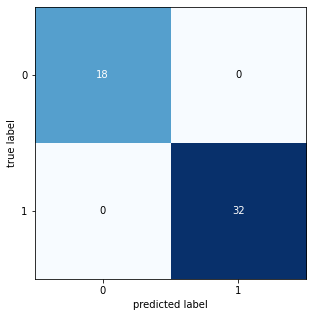

avg accuraccy Ovarian Cancer =  0.996078431372549
avg F1_Score Ovarian Cancer =  0.9956503198294243
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9782515991471215
Running Time:  47.694522067002254
gene : [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 

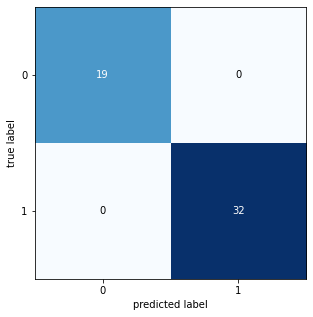

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

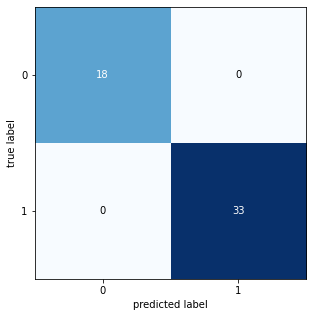

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

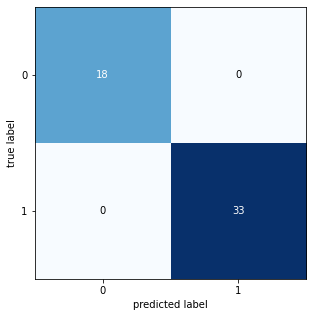

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

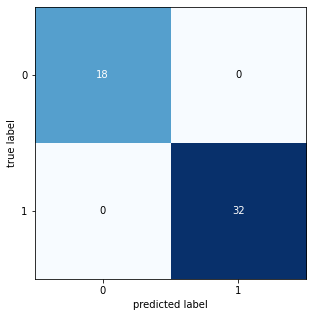

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

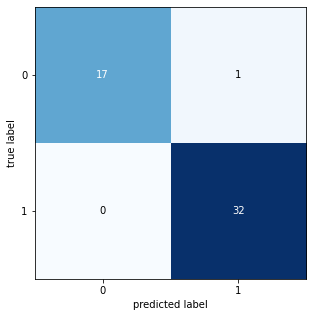

avg accuraccy Ovarian Cancer =  0.9960000000000001
avg F1_Score Ovarian Cancer =  0.9956043956043956
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.98
min F1_Score Ovarian Cancer =  0.9780219780219781
Running Time:  51.714503240997146
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 1

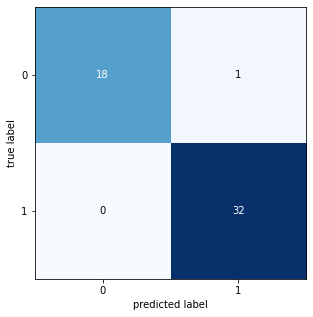

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

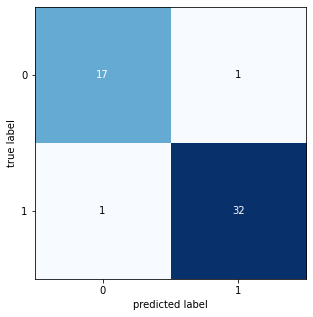

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

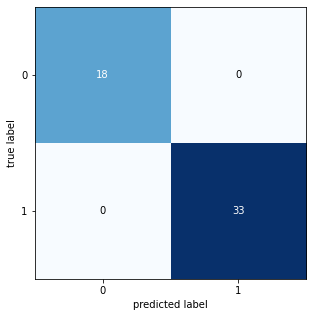

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

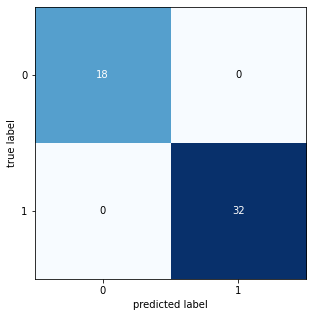

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

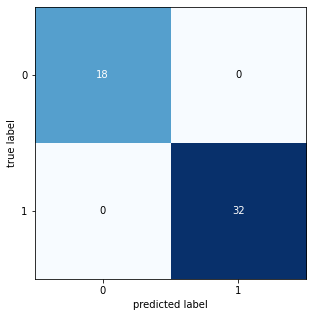

avg accuraccy Ovarian Cancer =  0.9882352941176471
avg F1_Score Ovarian Cancer =  0.9871729771729771
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9607843137254902
min F1_Score Ovarian Cancer =  0.9570707070707071
Running Time:  48.900990280999395
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113

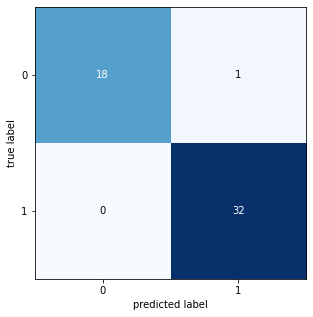

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

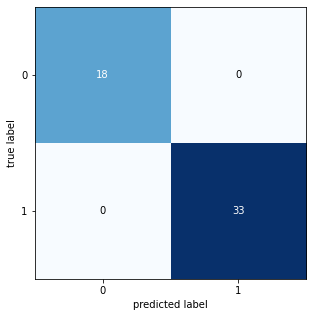

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

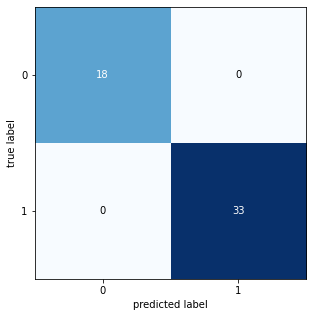

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

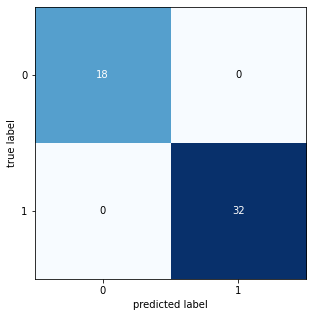

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

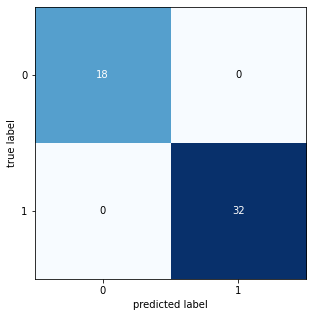

avg accuraccy Ovarian Cancer =  0.996078431372549
avg F1_Score Ovarian Cancer =  0.9957588357588356
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  47.11994366100407
gene : [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 1

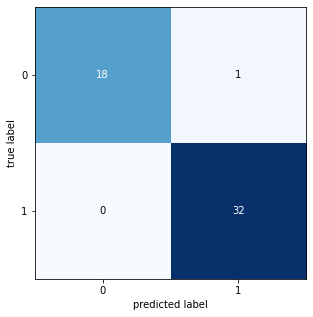

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

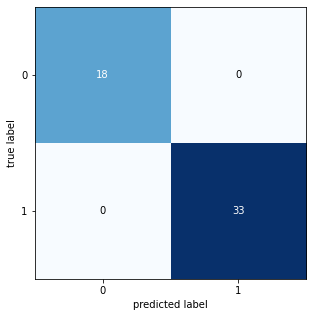

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

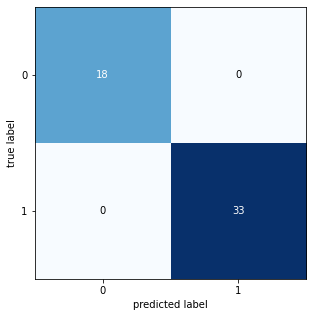

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

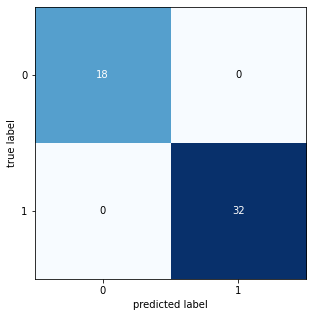

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

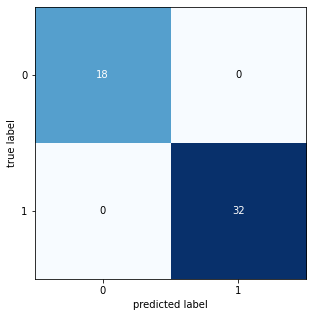

avg accuraccy Ovarian Cancer =  0.996078431372549
avg F1_Score Ovarian Cancer =  0.9957588357588356
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  48.43006471699482
gene : [0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 1

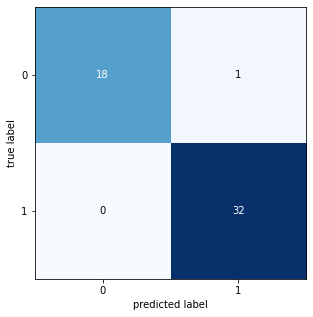

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

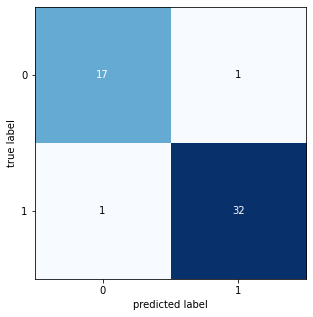

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

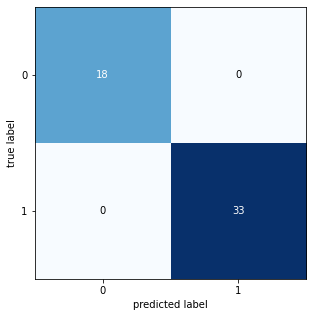

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

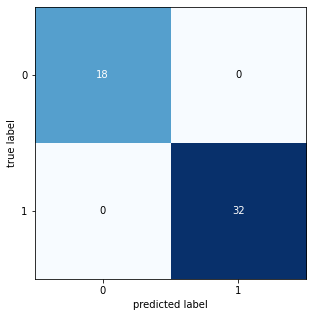

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

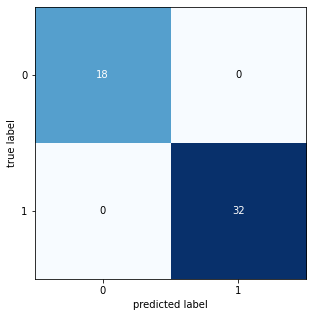

avg accuraccy Ovarian Cancer =  0.9882352941176471
avg F1_Score Ovarian Cancer =  0.9871729771729771
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9607843137254902
min F1_Score Ovarian Cancer =  0.9570707070707071
Running Time:  48.09217847599939
gene : [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 

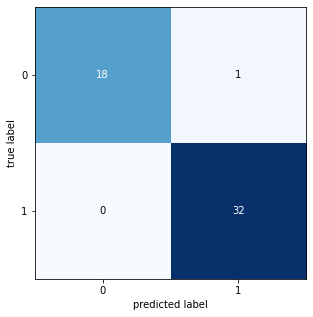

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

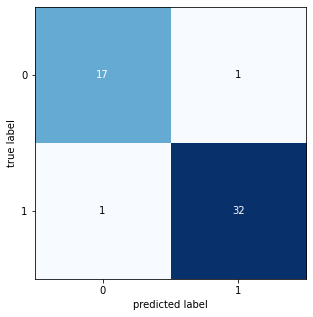

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

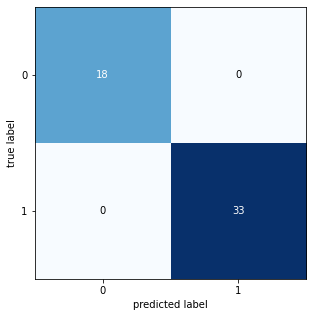

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

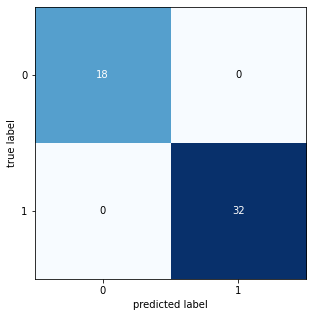

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

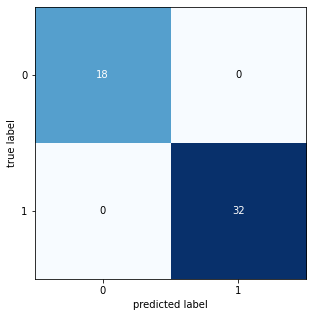

avg accuraccy Ovarian Cancer =  0.9882352941176471
avg F1_Score Ovarian Cancer =  0.9871729771729771
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9607843137254902
min F1_Score Ovarian Cancer =  0.9570707070707071
Running Time:  47.63622204000421
gene : [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 

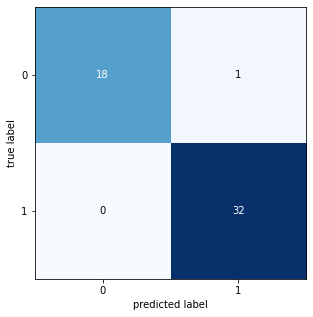

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

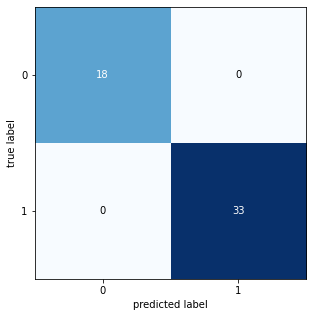

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

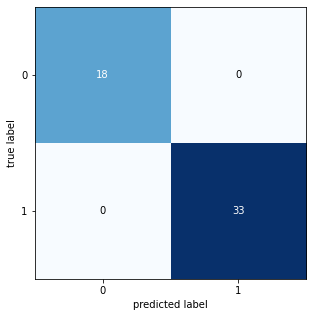

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

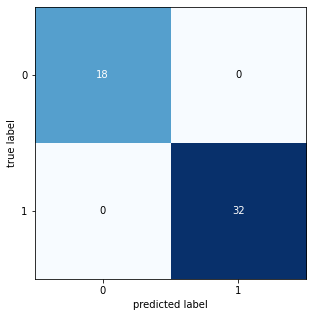

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

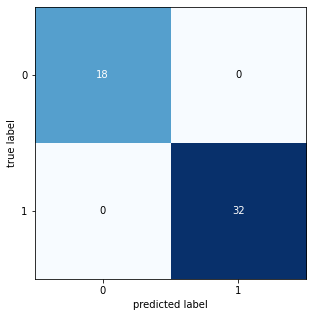

avg accuraccy Ovarian Cancer =  0.996078431372549
avg F1_Score Ovarian Cancer =  0.9957588357588356
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  48.48426164700504
gene : [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 1

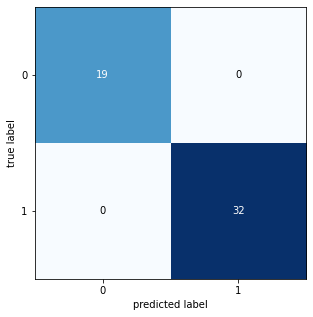

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

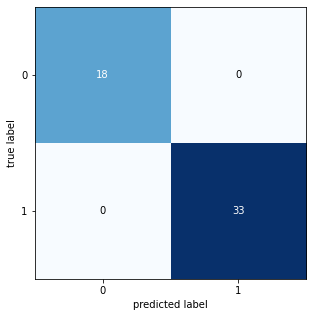

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

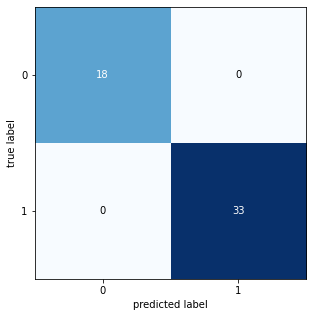

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

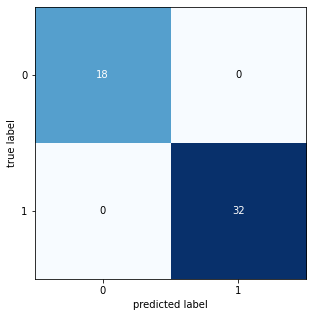

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

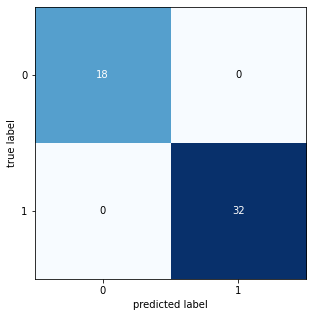

avg accuraccy Ovarian Cancer =  1.0
avg F1_Score Ovarian Cancer =  1.0
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  1.0
min F1_Score Ovarian Cancer =  1.0
Running Time:  47.3014383799964
gene : [0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 119 120 121 122 123 124 125 126 127 129 132 134
 

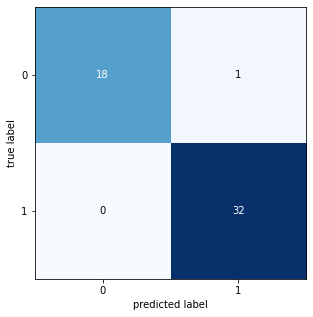

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

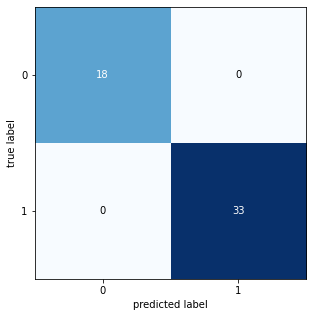

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

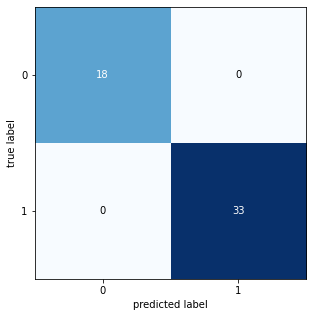

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

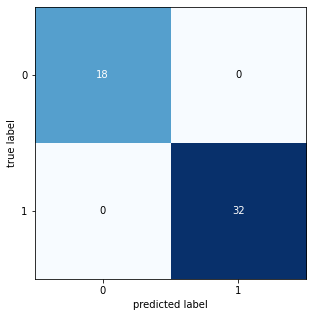

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

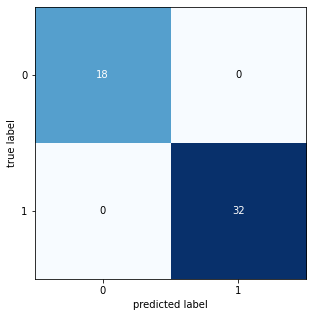

avg accuraccy Ovarian Cancer =  0.996078431372549
avg F1_Score Ovarian Cancer =  0.9957588357588356
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9803921568627451
min F1_Score Ovarian Cancer =  0.9787941787941788
Running Time:  47.66510176200245
gen terbaik : [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1]
F-1 Score terbaik : 1.0  || Akurasi terbaik : 1.0  || jumlah fitur : 37

Running Time:  483.2514838520001


In [14]:
Ovarian_IG_GA = GeneticAlgorithm(Ovarian_IG, 3)

Generation : 0
gene : [0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 119 120 121 122 123 124 125 126 127 129 132 134
 135 138 139 140 142 143 144 146 147 148 149 150 151 152 153 154 155 156
 157 158 160 161 162 164 165 166 167 168 169 170 171 172 173 174 175 178
 179 180 182 183 185 186 187 188 190 191 193 194 196 197 198 199 200 201
 202 203 204

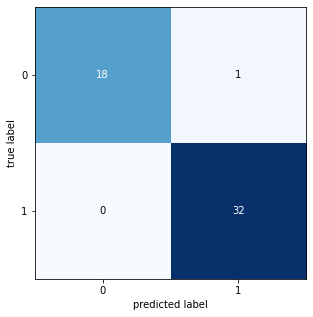

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

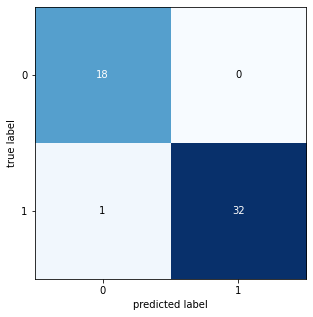

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

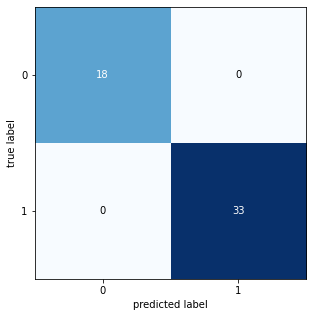

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

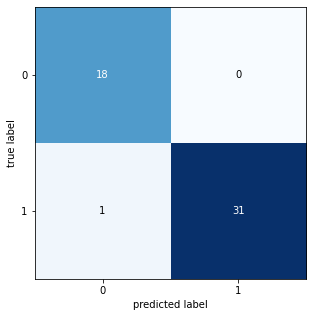

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

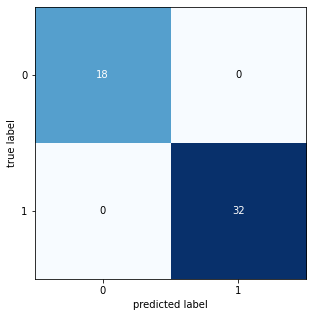

avg accuraccy Ovarian Cancer =  0.9881568627450982
avg F1_Score Ovarian Cancer =  0.9872276672276673
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.98
min F1_Score Ovarian Cancer =  0.9785499785499785
Running Time:  48.71141506500135
gene : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 11

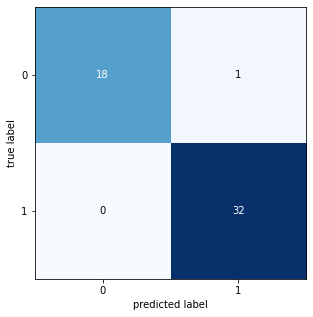

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

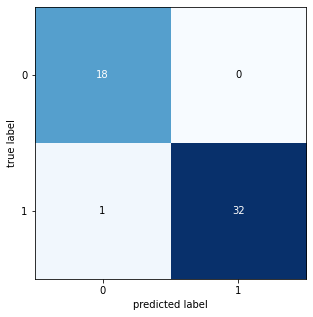

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

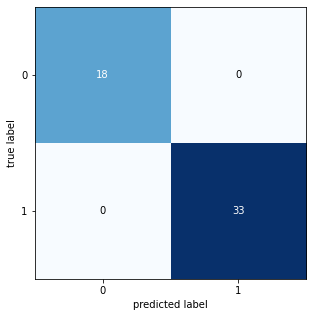

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

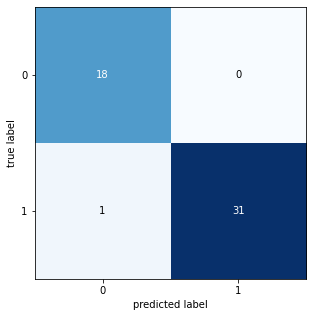

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

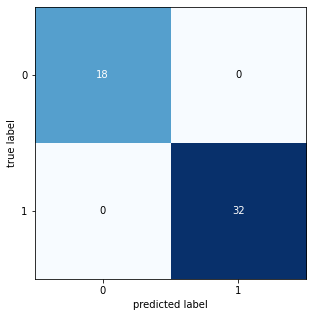

avg accuraccy Ovarian Cancer =  0.9881568627450982
avg F1_Score Ovarian Cancer =  0.9872276672276673
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.98
min F1_Score Ovarian Cancer =  0.9785499785499785
Running Time:  44.9433641229989
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 119

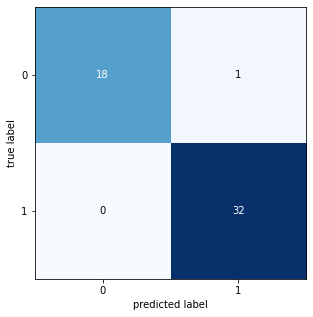

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

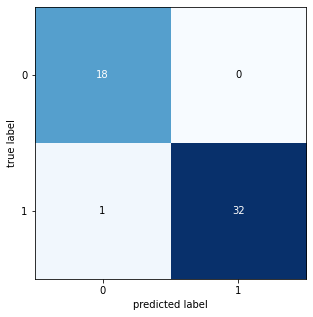

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

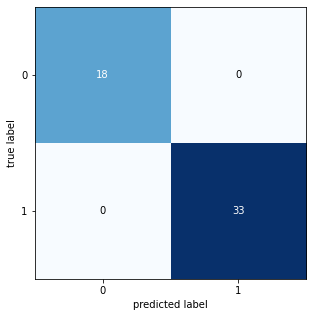

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

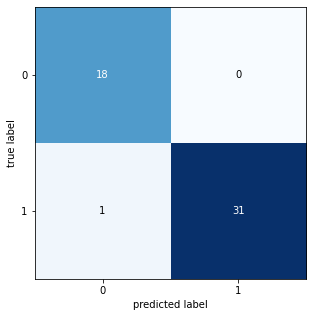

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

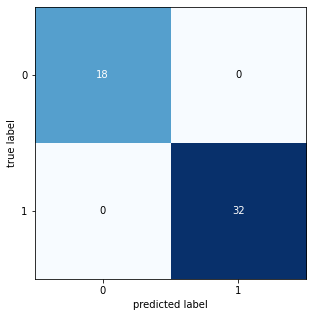

avg accuraccy Ovarian Cancer =  0.9881568627450982
avg F1_Score Ovarian Cancer =  0.9872276672276673
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.98
min F1_Score Ovarian Cancer =  0.9785499785499785
Running Time:  37.629071069997735
gene : [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 1

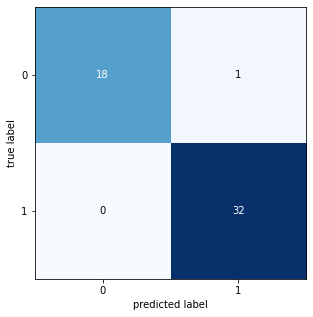

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

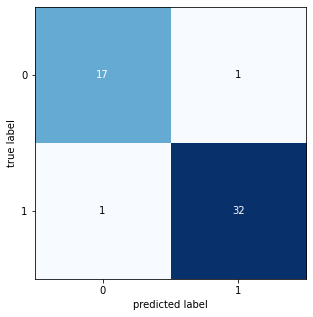

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

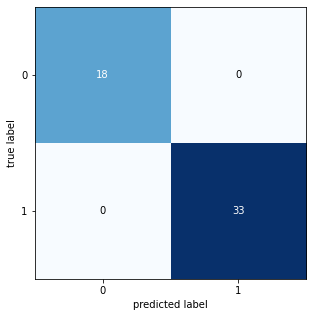

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

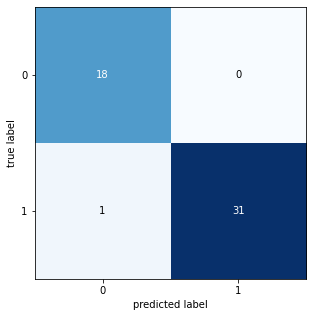

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

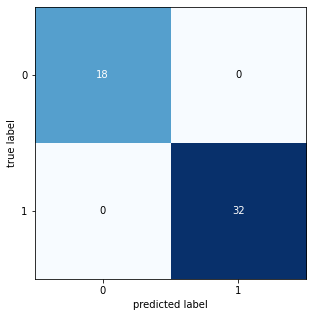

avg accuraccy Ovarian Cancer =  0.9842352941176472
avg F1_Score Ovarian Cancer =  0.9828829728829728
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9607843137254902
min F1_Score Ovarian Cancer =  0.9570707070707071
Running Time:  39.65776235699741
gene : [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 

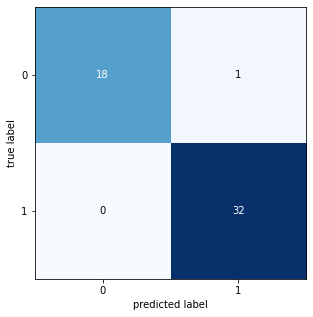

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

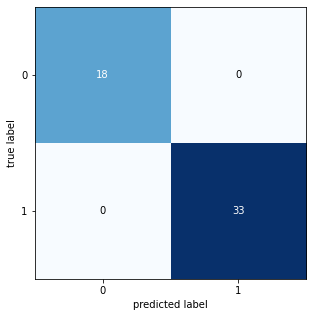

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

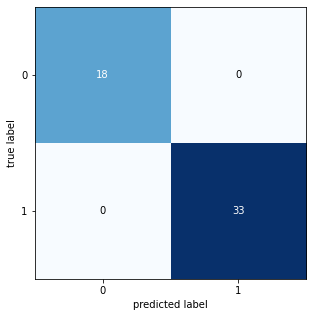

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

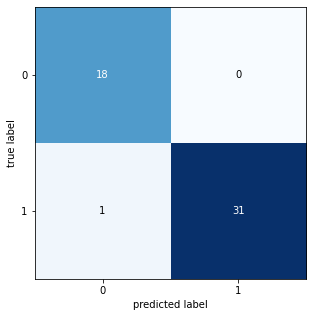

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

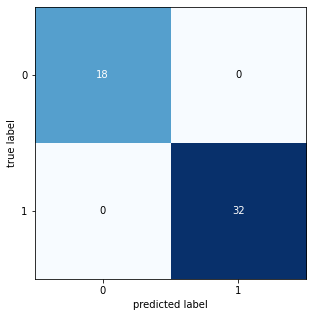

avg accuraccy Ovarian Cancer =  0.9920784313725491
avg F1_Score Ovarian Cancer =  0.9914688314688315
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.98
min F1_Score Ovarian Cancer =  0.9785499785499785
Running Time:  40.42384432599647
gene : [1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 11

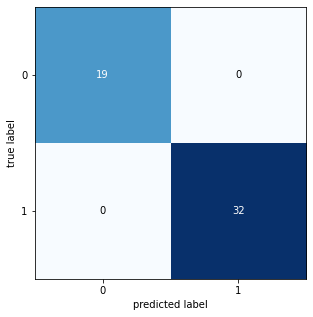

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

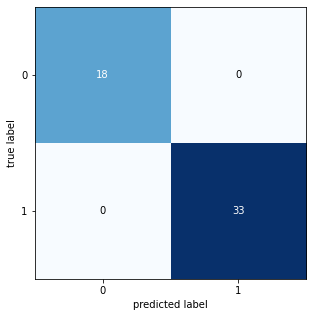

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

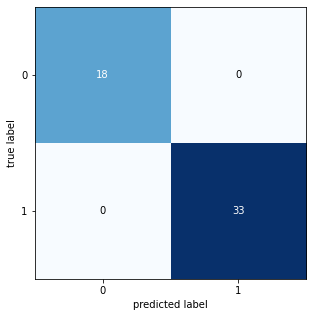

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

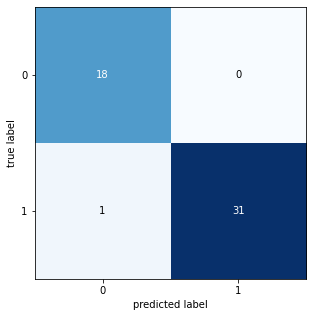

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

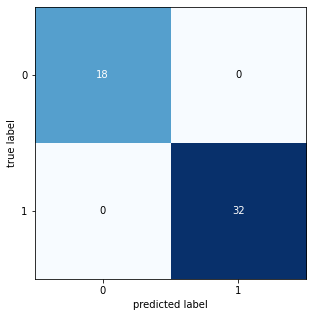

avg accuraccy Ovarian Cancer =  0.9960000000000001
avg F1_Score Ovarian Cancer =  0.9957099957099956
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.98
min F1_Score Ovarian Cancer =  0.9785499785499785
Running Time:  41.98281170200062
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 11

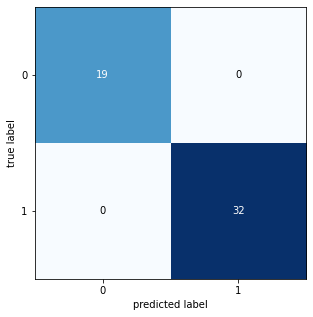

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

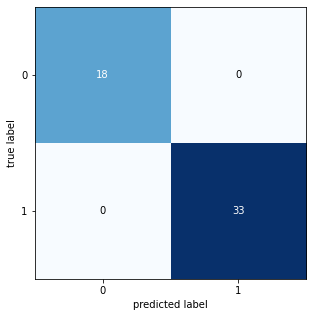

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

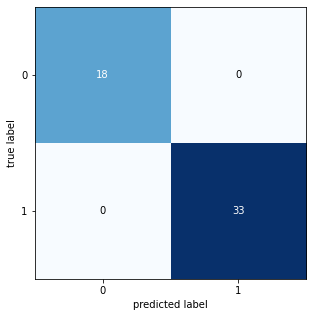

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

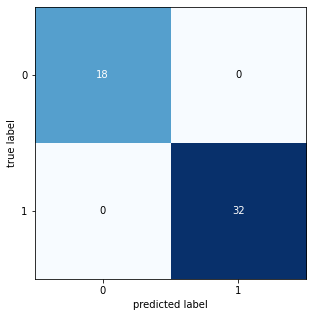

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

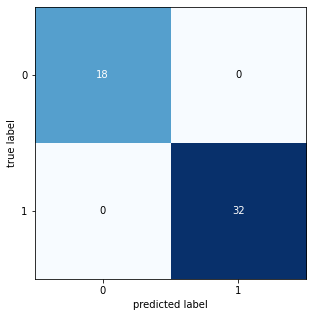

avg accuraccy Ovarian Cancer =  1.0
avg F1_Score Ovarian Cancer =  1.0
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  1.0
min F1_Score Ovarian Cancer =  1.0
Running Time:  41.01066913300019
gene : [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 119 120 121 122 123 124 125 126 127 129 132 134


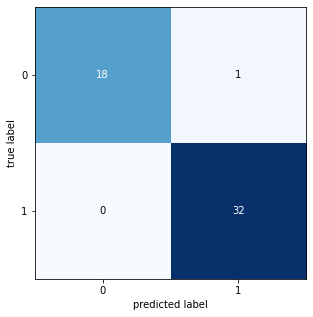

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

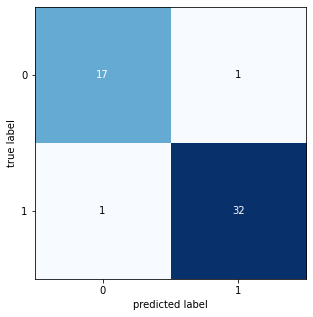

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

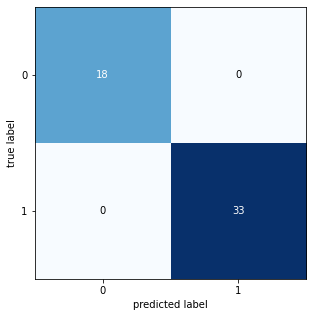

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

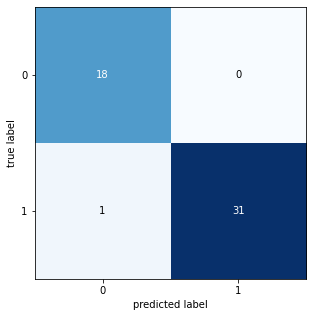

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

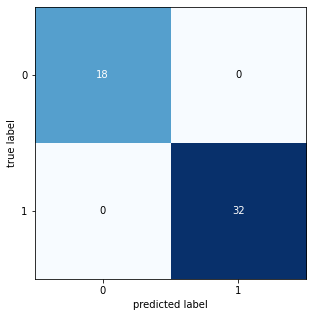

avg accuraccy Ovarian Cancer =  0.9842352941176472
avg F1_Score Ovarian Cancer =  0.9828829728829728
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.9607843137254902
min F1_Score Ovarian Cancer =  0.9570707070707071
Running Time:  40.34992263100139
gene : [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 

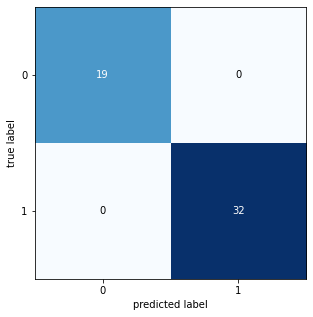

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

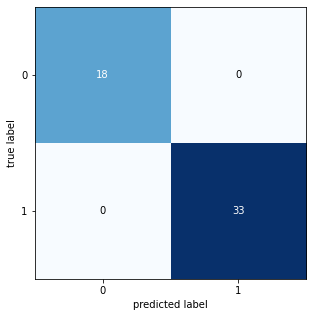

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

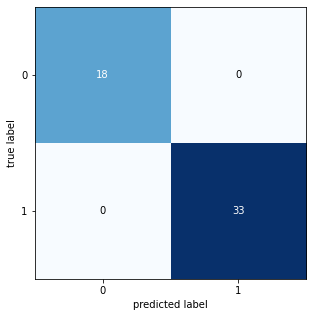

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

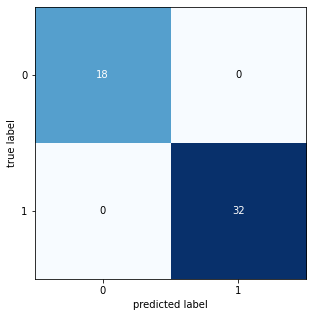

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

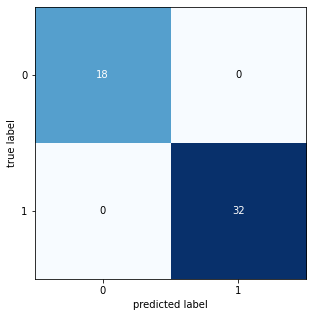

avg accuraccy Ovarian Cancer =  1.0
avg F1_Score Ovarian Cancer =  1.0
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  1.0
min F1_Score Ovarian Cancer =  1.0
Running Time:  38.889139132006676
gene : [0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]
Train : [  0   1   3   4   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  32  33  36  37  38  39  40  41  42
  44  45  47  48  49  50  51  53  54  55  56  57  58  59  61  62  63  64
  66  67  68  69  71  72  73  74  75  76  77  78  81  82  84  86  87  88
  91  92  93  94  95  96  97  98  99 100 101 103 105 106 107 108 109 110
 111 112 113 114 115 117 119 120 121 122 123 124 125 126 127 129 132 134

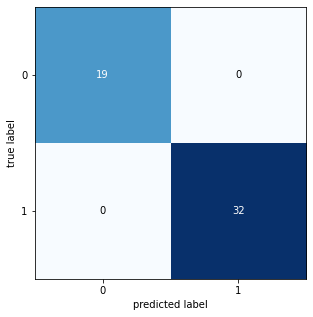

Train : [  0   1   2   5   7   8   9  10  12  13  14  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  52  53  54  55  58  59  60  62  63  65
  66  68  70  71  72  73  74  75  77  78  79  80  82  83  84  85  88  89
  90  91  93  94  95  97  99 100 101 102 104 106 107 109 110 112 114 116
 117 118 120 121 122 124 126 127 128 129 130 131 132 133 134 135 136 137
 139 140 141 143 145 148 149 150 152 154 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 172 173 175 176 177 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 207 209 210 212 213 214 215 216 217 218 220 221 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 238 239 241 242 244 245 246 247 248
 249 250 251 252] Test : [  3   4   6  11  21  37  38  51  56  57  61  64  67  69  76  81  86  87
  92  96  98 103 105 108 111 113 115 119 123 125 138 142 144 146 147 151
 153 155 156 171 1

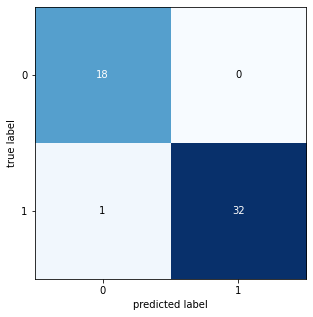

Train : [  1   2   3   4   5   6   7   9  11  12  14  15  16  17  21  22  23  24
  25  26  27  28  29  32  34  35  37  38  39  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  75  76  77  79  80  81  83  84  85  86  87  88  89
  90  91  92  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 118 119 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 153 154 155 156 158 159 161 163 164 165 168 171 172 173
 174 175 176 177 178 179 181 182 183 184 185 186 187 189 191 192 195 197
 198 199 200 201 203 204 206 207 208 209 210 211 213 214 216 218 219 220
 222 223 224 229 230 231 232 233 234 236 238 239 240 241 243 244 245 248
 249 250 251 252] Test : [  0   8  10  13  18  19  20  30  31  33  36  40  41  42  73  74  78  82
  93 117 124 148 152 157 160 162 166 167 169 170 180 188 190 193 194 196
 202 205 212 215 2

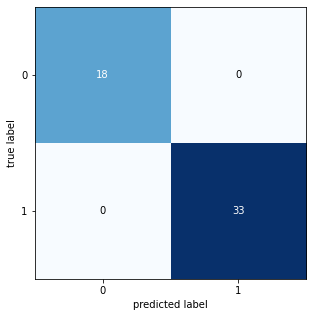

Train : [  0   2   3   4   6   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  25  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  54  56  57  59  60  61  62  64  65
  67  69  70  72  73  74  76  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  93  96  98  99 100 101 102 103 104 105 107 108 110 111 113
 115 116 117 118 119 120 121 122 123 124 125 126 128 130 131 132 133 136
 137 138 139 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 162 163 165 166 167 169 170 171 173 174 175 176 177
 178 180 181 183 184 185 187 188 189 190 191 192 193 194 195 196 197 200
 201 202 203 204 205 206 207 208 209 210 211 212 215 217 219 221 222 223
 225 226 227 228 229 233 234 235 236 237 238 240 241 242 243 244 246 247
 248 249 250 251 252] Test : [  1   5   7  17  23  24  28  29  48  55  58  63  66  68  71  75  77  88
  94  95  97 106 109 112 114 127 129 134 135 140 161 164 168 172 179 182
 186 198 199 2

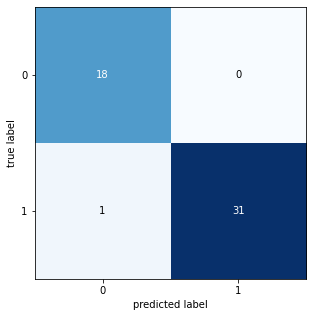

Train : [  0   1   2   3   4   5   6   7   8  10  11  12  13  15  17  18  19  20
  21  22  23  24  27  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  46  48  51  52  55  56  57  58  60  61  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  92  93  94  95  96  97  98 102 103 104 105 106 108 109 111 112 113
 114 115 116 117 118 119 123 124 125 127 128 129 130 131 133 134 135 136
 137 138 140 141 142 144 145 146 147 148 151 152 153 155 156 157 159 160
 161 162 163 164 166 167 168 169 170 171 172 174 176 177 178 179 180 181
 182 184 186 188 189 190 192 193 194 195 196 198 199 201 202 205 206 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 239 240 241 242 243 244 245 246
 247 248 249 250 251] Test : [  9  14  16  25  26  32  39  44  45  47  49  50  53  54  59  62  72  84
  91  99 100 101 107 110 120 121 122 126 132 139 143 149 150 154 158 165
 173 175 183 1

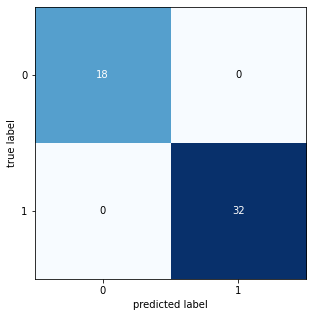

avg accuraccy Ovarian Cancer =  0.9920784313725491
avg F1_Score Ovarian Cancer =  0.9914688314688315
max accuraccy Ovarian Cancer =  1.0
max F1_Score Ovarian Cancer =  1.0
min accuraccy Ovarian Cancer =  0.98
min F1_Score Ovarian Cancer =  0.9785499785499785
Running Time:  42.716162914999586
gen terbaik : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 1.0  || Akurasi terbaik : 1.0  || jumlah fitur : 55

Running Time:  416.49270480799896


In [15]:
Ovarian_IG_GA = GeneticAlgorithm(Ovarian_IG, 4)